In [1]:
# Import all modules
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from scipy.io import loadmat
from restrictedPropagation import restrictedPropagation

## Guide: Restricted Propagation Algorithm

This Notebook is meant to be used as a guide for implementing the **Restricted Propagation** algorithm to segment the ventricles of cardiac optoacoustic data. It will also help the user to load the data saved as .mat files, visualize the volumes dynamically, and perform the automatic segmentation with the proposed algorithm.

In [2]:
# Load the data from the .mat file using loadmat function

data_dir = './tg_chunk_1.mat' # Path to the .mat file
matlab_variable_name = 'chunk_data' # Name of the variable in the .mat file
volume_4d = loadmat(data_dir)[matlab_variable_name]

# If due to the size the volumes where stored in "chuncks" we can concatenate them

# Initialize an empty list to store chunks
chunks = []
# Load each chunk and append to the list
for i in range(1, 4):  # Assuming there are 3 files
    chunk_data = loadmat(f'./tg_chunk_{i}.mat')[matlab_variable_name]
    chunks.append(chunk_data)

# Ensure all chunks have the same number of dimensions
max_dims = max(chunk.ndim for chunk in chunks)
for i, chunk in enumerate(chunks):
    if chunk.ndim < max_dims:
        # Expand dimensions to match the maximum number of dimensions
        chunks[i] = np.expand_dims(chunk, axis=-1)

# Concatenate the chunks along the time dimension
volume_4d = np.concatenate(chunks, axis=3)

print("Size of the volume_4d: ", volume_4d.shape)

Size of the volume_4d:  (128, 128, 128, 300)


A difference beween Python and MATLAB is the indexing of arrays. The 4D volume variable has shape (128, 128, 128, 300) which means that the indices for the first dimension go from 0 to 127.

In [3]:
# This code will create a slider to select the frame to visualize

def plot_slices(x_slice, y_slice, z_slice, t_slice):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    img_x = volume_4d[x_slice, :, :, t_slice]
    img_y = volume_4d[:, y_slice, :, t_slice]
    img_z = volume_4d[:, :, z_slice, t_slice]

    axes[0].imshow(img_x, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'X Slice {x_slice} - Time {t_slice}')

    axes[1].imshow(img_y, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f'Y Slice {y_slice} - Time {t_slice}')

    axes[2].imshow(img_z, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title(f'Z Slice {z_slice} - Time {t_slice}')

    plt.show()

x_slice_slider = widgets.IntSlider(min=0, max=(volume_4d.shape[0]-1), step=1, value=0, description='X Slice')
y_slice_slider = widgets.IntSlider(min=0, max=(volume_4d.shape[1]-1), step=1, value=0, description='Y Slice')
z_slice_slider = widgets.IntSlider(min=0, max=(volume_4d.shape[2]-1), step=1, value=0, description='Z Slice')
t_slice_slider = widgets.IntSlider(min=0, max=(volume_4d.shape[3]-1), step=1, value=0, description='T Slice')

interact(plot_slices, x_slice=x_slice_slider, y_slice=y_slice_slider, z_slice=z_slice_slider, t_slice=t_slice_slider)

interactive(children=(IntSlider(value=0, description='X Slice', max=127), IntSlider(value=0, description='Y Sl…

<function __main__.plot_slices(x_slice, y_slice, z_slice, t_slice)>

Text(0.5, 1.0, 'AutoSegment Result')

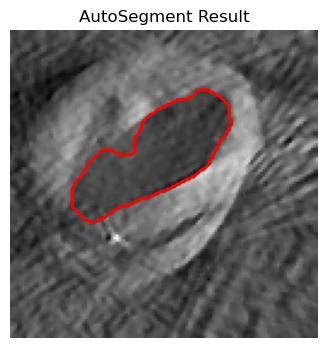

In [4]:
# Now lets visualize the result of using the autoSegment function to the central slice
from autoSegment import autoSegment

""" The autoSegment function is defined as follows:
Inputs
----------
slice : 2D array (N,M)
    Image slice to be segmented.
denoised_method : String
    "tvl1": Total variation L1 denoising.
    "median": Median filter.
active_contours_method : String
    "acwe": Chan-Vese active contours without edges.
    "geodesic": Geodesic active contours.
Returns
-------
mask : 2D array (N,M)
    Binary mask of the segmented image slice.
"""

# Define the central slice
central_slice = volume_4d.shape[2] // 2
time_point = 170
slice = volume_4d[:, central_slice, :, time_point]
central_mask = autoSegment(slice, denoised_method='tvl1', active_contours_method='acwe')

# Visualize the result
plt.figure(figsize=(4, 4))
plt.imshow(slice, cmap='gray')
plt.gca().contour(central_mask, colors='r', linewidths=0.6)
plt.axis('off')
plt.title('AutoSegment Result')

In [5]:
# The fuction autoSegment is directly used in the Restricted Propagation function
# The restrictedPropagation function is defined as follows:
from restrictedPropagation import restrictedPropagation
""" The restrictedPropagation function is defined as follows:
    Inputs
    ----------
    tensor_4d : 4D array (N,M,L,T)
        4D tensor to propagate the mask.
    t_slice : Integer
        Index of the time point of the volume to segment.
    dimension : Integer
        Dimension to do the segmentation (0/1/2).
    denoised_method : String
        "tvl1": Total variation L1 denoising.
        "median": Median filter.
    active_contours_method : String
        "acwe": Chan-Vese active contours without edges.
        "geodesic": Geodesic active contours.
    Returns
    -------
    propagated_masks : 3D array (N,M,L)
        Set of propagated masks (Volume).
"""
t_slice = 170
dimension = 1 # 0 for x, 1 for y, 2 for z
propagated_mask = restrictedPropagation(volume_4d, t_slice, dimension, denoised_method='tvl1', active_contours_method='acwe')
print("Size of the propagated_mask: ", propagated_mask.shape)


Size of the propagated_mask:  (128, 128, 128)


In [8]:
# This code will create a slider to select the frame to visualize
t_slice = 170
dimension = 1 # 0 for x, 1 for y, 2 for z
def plot_slices_with_mask(slice_index):
    fig = plt.figure(figsize=(4, 4))

    if dimension == 0:
        img = volume_4d[slice_index, :, :, t_slice]
    elif dimension == 1:
        img = volume_4d[:, slice_index, :, t_slice]
    elif dimension == 2:
        img = volume_4d[:, :, slice_index, t_slice]
    else:
        raise ValueError("Invalid dimension value. Please choose 0, 1, or 2.")
    
    plt.imshow(img, cmap='gray')
    plt.gca().contour(propagated_mask[:,:, slice_index], colors='r', linewidths=0.6)
    plt.axis('off')
    plt.title(f'Slice {slice_index}')
    plt.show()

slice_indx_slider = widgets.IntSlider(min=0, max=(volume_4d.shape[dimension]-1), step=1, value=0, description='Slice Index')

interact(plot_slices_with_mask, slice_index = slice_indx_slider)

interactive(children=(IntSlider(value=0, description='Slice Index', max=127), Output()), _dom_classes=('widget…

<function __main__.plot_slices_with_mask(slice_index)>

In [13]:
# Run this to segment all the time points
from tqdm import tqdm

propagated_masks = []
for t_slice in tqdm(range(volume_4d.shape[3])):
    propagated_mask = restrictedPropagation(volume_4d, t_slice, dimension, denoised_method='tvl1', active_contours_method='acwe')
    propagated_masks.append(propagated_mask)

propagated_masks = np.stack(propagated_masks, axis=-1)
print("Size of the propagated_masks: ", propagated_masks.shape)

  2%|▏         | 5/300 [02:54<2:51:30, 34.88s/it]


KeyboardInterrupt: 